In [5]:
import torch
import sys
import yaml
from torchvision import transforms
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import glob

sys.path.append('../')
from models.resnet_base_network import ResNet18

# Config & Device
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([transforms.ToTensor()])

config = yaml.load(open("../config/config.yaml", "r"), Loader=yaml.FullLoader)

# Unlabeled Dataset
class UnlabeledImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.paths = glob.glob(os.path.join(root, "*.jpg")) + glob.glob(os.path.join(root, "*.jpeg"))
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

train_dir = "/nmhs2/prema/imageprocessing/train_test_data/paddy_train"
test_dir  = "/nmhs2/prema/imageprocessing/train_test_data/paddy_test"

train_dataset = UnlabeledImageDataset(train_dir, transform=transform)
test_dataset  = UnlabeledImageDataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Load BYOL encoder
encoder = ResNet18(**config['network'])
load_params = torch.load(
    '/nmhs2/prema/imageprocessing/byol/PyTorch-BYOL/runs/byol_experiment/checkpoints/model.pth',
    map_location=device
)
if 'online_network_state_dict' in load_params:
    encoder.load_state_dict(load_params['online_network_state_dict'])
    print("BYOL weights loaded")

encoder = torch.nn.Sequential(*list(encoder.children())[:-1])
encoder = encoder.to(device)


# Feature Extraction
def get_features_from_encoder(encoder, loader):
    features = []
    encoder.eval()
    with torch.no_grad():
        for imgs in loader:
            imgs = imgs.to(device)
            feat = encoder(imgs)
            if len(feat.shape) > 2:
                feat = torch.mean(feat, dim=[2, 3])  # flatten spatial dims
            features.append(feat.cpu())
    return torch.cat(features, dim=0)

x_train = get_features_from_encoder(encoder, train_loader)
x_test  = get_features_from_encoder(encoder, test_loader)

print("Train features:", x_train.shape)
print("Test features:", x_test.shape)


# Save features to .npy
save_dir = "/nmhs2/prema/imageprocessing/byol/features"
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "x_train2.npy"), x_train.numpy())
np.save(os.path.join(save_dir, "x_test2.npy"), x_test.numpy())

print(f"✅ Saved x_train.npy and x_test.npy to {save_dir}")


/home/prema/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/prema/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_3099318/2827319604.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This 

BYOL weights loaded
Train features: torch.Size([2384, 512])
Test features: torch.Size([654, 512])
✅ Saved x_train.npy and x_test.npy to /nmhs2/prema/imageprocessing/byol/features


Train features: (2384, 512)
Test features: (654, 512)
Cluster assignments (train): (array([0, 1], dtype=int32), array([2201,  183]))
Cluster assignments (test): (array([0, 1], dtype=int32), array([579,  75]))


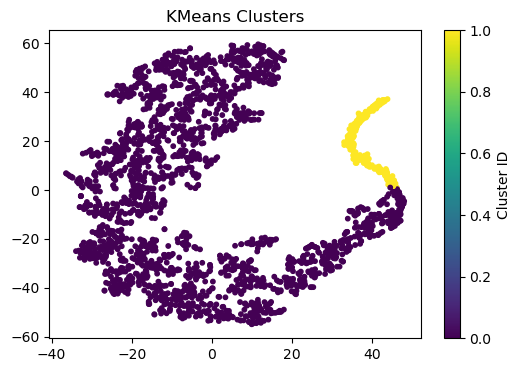

In [7]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Load features
x_train = np.load("/nmhs2/prema/imageprocessing/byol/features/x_train2.npy")
x_test  = np.load("/nmhs2/prema/imageprocessing/byol/features/x_test2.npy")

print("Train features:", x_train.shape)
print("Test features:", x_test.shape)


# Apply KMeans clustering
num_clusters = 2  # diseased & non-diseased (unsupervised guess)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(x_train)

train_clusters = kmeans.predict(x_train)
test_clusters  = kmeans.predict(x_test)

print("Cluster assignments (train):", np.unique(train_clusters, return_counts=True))
print("Cluster assignments (test):", np.unique(test_clusters, return_counts=True))


# Dimensionality Reduction for Visualization
# Step 1: PCA for speed
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)

# Step 2: t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_pca)


# Plot clusters
plt.figure(figsize=(6,4))
plt.scatter(x_train_tsne[:,0], x_train_tsne[:,1], c=train_clusters, cmap="viridis", s=10)
plt.title("KMeans Clusters")
plt.colorbar(label="Cluster ID")
plt.show()


In [4]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Load features
x_train = np.load("/nmhs2/prema/imageprocessing/byol/features/x_train2.npy")
x_test  = np.load("/nmhs2/prema/imageprocessing/byol/features/x_test2.npy")


# Apply KMeans clustering
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(x_train)

train_clusters = kmeans.predict(x_train)
test_clusters  = kmeans.predict(x_test)


# Silhouette Score
sil_train = silhouette_score(x_train, train_clusters)
sil_test  = silhouette_score(x_test, test_clusters)

print(f"Silhouette Score (Train): {sil_train:.4f}")
print(f"Silhouette Score (Test) : {sil_test:.4f}")


Silhouette Score (Train): 0.8404
Silhouette Score (Test) : 0.8231
